# Fake News dataset exploration & preprocessing
by Marcin Rybok

In [34]:
import pandas as pd
import seaborn as sns

from collections import Counter

In [35]:
bodies  = pd.read_csv('data/fake_news/bodies.csv')
stances = pd.read_csv('data/fake_news/stances.csv')

In [36]:
# Check for null values
bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [37]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [38]:
# Check for duplicates
unique_count = bodies.groupby('articleBody').agg(['unique', 'nunique'])
duplicates   = unique_count[unique_count['Body ID']['nunique'] > 1]['Body ID']['unique'].tolist()

print(f'Number of body duplicates: {len(duplicates)}')

Number of body duplicates: 14


In [39]:
# Map second duplicate in a pair to ID of the first body
duplicates = {non_first_duplicate: ids[0] for ids in duplicates for non_first_duplicate in ids[1:]}

# Remove duplicates
bodies = bodies.drop_duplicates(subset='articleBody', keep='first')

print(f'Number of bodies after duplicate removal: {len(bodies)}')

Number of bodies after duplicate removal: 1669


In [40]:
# Fix the Body IDs of removed duplicate bodies in the Stances table
stances['Body ID'] = stances['Body ID'].apply(lambda body_id: duplicates[body_id] if body_id in duplicates else body_id)

# Remove duplicated Headline - Body pairs
stances = stances.drop_duplicates(subset=['Headline', 'Body ID'], keep='first')

print(f'Number of headline-body pairs after duplicate removal: {len(stances)}')

Number of headline-body pairs after duplicate removal: 49538


In [41]:
unique_heads = set(stances["Headline"])

print(f'Number of unique headlines: {len(unique_heads)}')

Number of unique headlines: 1648


In [42]:
# Replace headline by ID in Stances table
# Useful later for faster tokenizing (1,500 instead of 50,000)
max_body_id = max(stances['Body ID']) + 1
head_to_id  = {headline: idx + max_body_id for idx, headline in enumerate(unique_heads)}

stances['Headline'] = stances['Headline'].apply(lambda headline: head_to_id[headline])

In [43]:
# Check for data points with conflicting labels
num_conflicts = (stances.groupby(['Headline', 'Body ID']).agg('nunique') > 1)['Stance'].sum()

print(f'Num conflicting data points: {num_conflicts}')

Num conflicting data points: 0


In [44]:
# Check class distribution
dist = sorted(Counter(stances['Stance']).items(), key=lambda x: x[1])

print(f'Dataset size: {len(stances)}\n')
print('Class distribution:')

for label, count in dist:
    print(f'    {label:<9s}: {count * 100 / len(stances):>5.2f}%, ({count:>5d})')

Dataset size: 49538

Class distribution:
    disagree :  1.67%, (  829)
    agree    :  7.35%, ( 3643)
    discuss  : 17.77%, ( 8804)
    unrelated: 73.20%, (36262)


## Dataset partitioning problem

For ML we need to split the dataset into train / validation / test sets.
The project GitHub repository offers a ready test set, so I am going to use it.
I need to split the available dataset to train and validation only.

Splitting aims:
- Maintain original class distribution in train & valid set
- The splits are mutually exclusive

**Problem**:
The mapping between headlines and bodies is many-to-many.
We cannot have a headline that occurs both in train set and validation set pair.
Otherwise, we have data leakage from train to the validation set.
Validation set will produce over-optimistic estimates in hyperparameter tunning.

We need to assign each headline and body either to train or validation dataset.
Then remove the Stance pairings in which headline and body are not in the same set.
*(The removal is temporary for hyperparameter tunning only. After finding good hyperparameters we retrain on the entire dataset.)*
There are $2^{N}$ possible splits to consider ($N$ being number of bodies and headlines).
Combinatorial problem - too costly to consider all splits.
The problem is a graph coloring one so use breadth-first search (BFS) to find a suboptimal split.

New splitting aims:
- Maintain original class distribution in train & valid set
- The pairing splits are mutually exclusive
- Each Headline and Body is assigned to train or valid set only.
- Minimize the number of inter-split Body-Headline connections, to maximize the number of training examples.

The implementation is in `util.split_data` function.

In [45]:
from util import split_data

In [46]:
new_stances = split_data(stances, valid_size=0.05, seed=6)

  0%|          | 0/2476 [00:00<?, ?it/s]

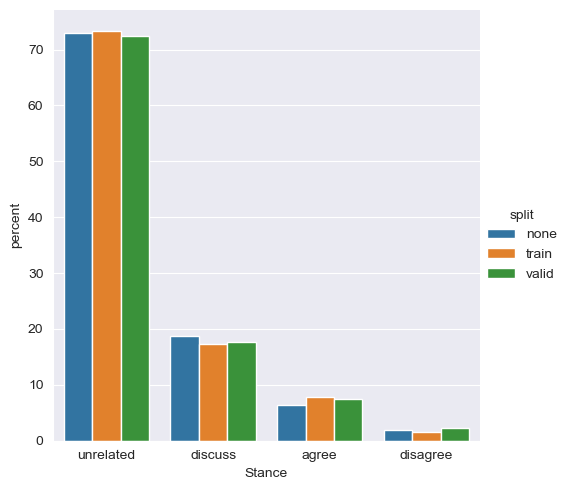

In [47]:
split_display = new_stances.groupby('split')['Stance'].value_counts(normalize=True).mul(100).rename('percent')

split_display.reset_index().pipe((sns.catplot, 'data'), x='Stance', y='percent', hue='split', kind='bar');

In [48]:
labels = {'unrelated': 0, 'agree': 1, 'disagree': 2, 'discuss': 3}

print(f'{" ":<5s} | total | data % | unrelated | {"agree":>8s} | disagree | {"discuss":>8s}')
print("-------------------------------------------------------------------")

for split in ['train', 'valid', 'none']:
    filtered = new_stances[new_stances['split'] == split]
    n = len(filtered)

    aux = lambda label: f'{((filtered["Stance"] == label).sum() * 100 / n):>8.2f}%'
    str_rep = " |".join([aux(label) for label in labels])
    print(f'{split:<5s} | {n:5d} | {(n * 100 / len(new_stances)):>5.2f}% |', str_rep)

      | total | data % | unrelated |    agree | disagree |  discuss
-------------------------------------------------------------------
train | 31161 | 62.90% |    73.40% |    7.80% |    1.52% |   17.27%
valid |  2501 |  5.05% |    72.49% |    7.52% |    2.36% |   17.63%
none  | 15876 | 32.05% |    72.92% |    6.45% |    1.86% |   18.77%


The algorithm I have used for data splitting produces well-balanced splits in terms of classes.
Drawback: many examples must be rejected.
I have tried different expansion method, that selected the least connected nodes for expansion in BFS.
The previous method rejected significantly less inter-split connections, but split class distributions varied significantly.
*(3 times lower proportion of "agree" examples in a train set compared to validation)*
There are no free-lunches :(

**Finally, I use 5% of Headline-Body pairings as the validation set. 63% pairs are left for training. The remaining 32% of data must be left out from the hyper-parameter tunning process, to prevent same examples in training and validation sets.**
*(I use 5% of data in validation set because when I have tried 10% the train set had only 40% of examples)*

### Digression
Creating more *"unrelated"* pairings by randomly assigning more headlines to bodies is a good data augmentation method.
Its unlikely that such random assignment would produce a *"related"* pair.
However, most of the pairings are already *"unrelated"*.
Headlines are paired with multiple bodies.
The method was probably already used in the dataset creation.